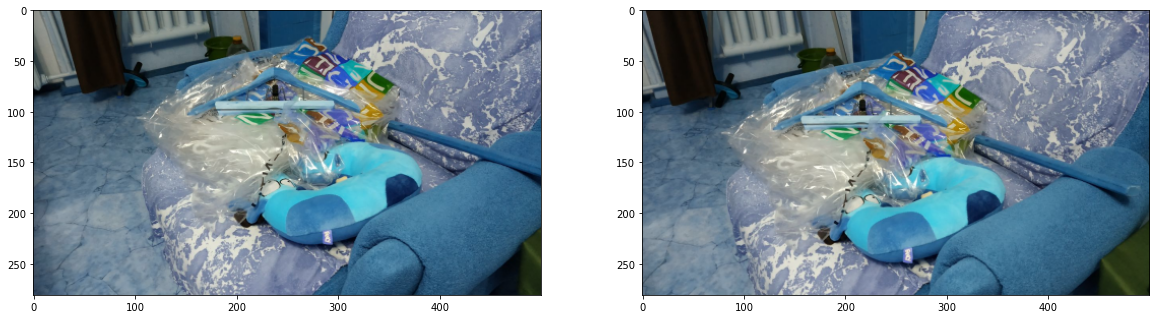

OpenCV results
688
669


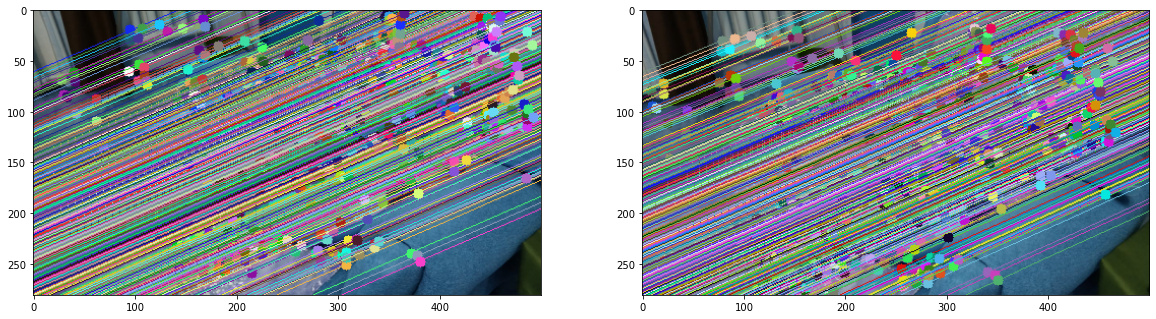

Our results
688
683


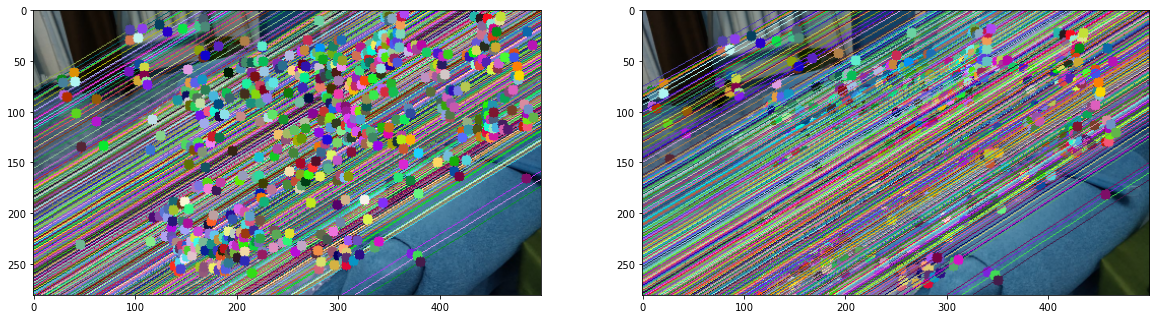

True

In [1]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import null_space

ratio = 0.75

def detectAndDescribe(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
def matchKeypoints(kps1, kps2, features1, features2, ratio):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(features1, features2, 2)
        pts1_ = []
        pts2_ = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                pts1_.append(m[0].trainIdx)
                pts2_.append(m[0].queryIdx)
        pts1 = np.float32([kps1[i] for i in pts2_])
        pts2 = np.float32([kps2[i] for i in pts1_])
        return (pts1, pts2)
    
def get_fundamental(pts1, pts2):
    X = []
    for i in range(7):
        vec = np.matmul([[pts1[i][0]], [pts1[i][1]], [1]],
                        [[pts2[i][0], pts2[i][1], 1]]).flatten()
        X.append(list(vec))
    F = null_space(X)
    F = F.T
    F1 = F[0]
    F1 = F1.reshape((3, 3))
    F1 /= F1[2][2]
    F2 = F[1]
    F2 = F2.reshape((3, 3))
    F2 /= F2[2][2]
    if np.linalg.matrix_rank(F1) == 2:
        return [F1]
    if np.linalg.matrix_rank(F2) == 2:
        return [F2]
    if np.linalg.matrix_rank(F1) < 2:
        return []
    if np.linalg.matrix_rank(F2) < 2:
        return []

    c1 = np.matmul(F2, np.linalg.inv(F1))
    c2 = np.matmul(F1, np.linalg.inv(F2))
    coeff = [np.linalg.det(F1),
             np.linalg.det(F1) * np.trace(c1),
             np.linalg.det(F2) * np.trace(c2),
             np.linalg.det(F2)]
    gammas = np.roots(coeff)
    gamma = [g for g in gammas if np.isreal(g)]
    answer = [(np.real(g) * F1 + F2) for g in gamma]
    answer = [a/a[2][2] for a in answer]
    return answer

def mod(x1, x2):
    return ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2 + (x1[2] - x2[2])**2)**0.5

def E(F, pts1, pts2, epsilon=10, show=0):
    result = 0
    F /= F[2][2]
    M = np.zeros((len(pts1)), np.int)
    for i in range(len(pts1)):
        c = np.matmul([pts1[i][0], pts1[i][1], 1], F)
        a = np.matmul(c, [[pts2[i][0]], [pts2[i][1]], [1]])[0]
        
        b = (c[0]**2 + c[1]**2)**0.5
        inc = int(abs(a / b) <= epsilon)
        if show == 1:
            print(a / b)
        result += inc
        M[i] = inc
    return result, M

def pick_random_7(pts1, pts2):
    rand_perm = np.random.permutation(len(pts1))
    pts1_ = []
    pts2_ = []
    for i in range(7):
        pts1_.append(pts1[rand_perm[i]])
        pts2_.append(pts2[rand_perm[i]])
    return pts1_, pts2_

def RANSAC(pts1, pts2, epsilon=10):
    F_best = np.zeros((3, 3), np.float32)
    E_best = -1
    M_best = np.zeros((len(pts1)), np.int)
    iterations = 1000
    while iterations > 0:
        pts1_, pts2_ = pick_random_7(pts1, pts2)
        F_cur = get_fundamental(pts1_, pts2_)
        if len(F_cur) > 0:
            for F_c in F_cur:
                E_cur, M_cur = E(F_c, pts1, pts2, epsilon)
                if E_cur > E_best:
                    E_best = E_cur
                    F_best = F_c
                    M_best = M_cur
        iterations -= 1
    return F_best, M_best
    
def draw(img, pts):
    _, c, _ = img.shape
    for pt in pts:
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img = cv2.circle(img, tuple(pt), 5, color, -1)
    return img
    
def drawlines(image1, image2, lines, pts1, pts2):
    _, c, _ = image1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
        image1 = cv2.circle(image1, tuple(pt1), 5, color, -1)
        image2 = cv2.circle(image2, tuple(pt2), 5, color, -1)
        image1 = cv2.line(image1, (x0, y0), (x1, y1), color, 1)
    return image1

nameA = "hangerL"
nameB = "hangerR"
sufix = ".jpeg"

imageA = cv2.imread(nameA + sufix)
imageB = cv2.imread(nameB + sufix)

imageA = imutils.resize(imageA, width=500)
imageB = imutils.resize(imageB, width=500)
h, w, _ = imageA.shape

imageA_ = imageA.copy()
imageB_ = imageB.copy()

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA)
plt.subplot(122), plt.imshow(imageB)
plt.show()

(kpsA, featuresA) = detectAndDescribe(imageA)
(kpsB, featuresB) = detectAndDescribe(imageB)

(ptsA, ptsB) = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio)
ptsA = np.int32(ptsA)
ptsB = np.int32(ptsB)

###############################################################

print("OpenCV results")

F, mask = cv2.findFundamentalMat(ptsA, ptsB, cv2.FM_LMEDS)
ptsA_ = ptsA[mask.ravel()==1]
ptsB_ = ptsB[mask.ravel()==1]

lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA.copy(), imageB.copy(), lines1, ptsA_, ptsB_)

lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB.copy(), imageA.copy(), lines2, ptsB_, ptsA_)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("res_cv_" + nameA + ".jpg", imageA1) 
cv2.imwrite("res_cv_" + nameB + ".jpg", imageA2)

print("Our results")

F, M = RANSAC(ptsB, ptsA, 3)
F /= F[2][2]
ptsA_ = ptsA[M==1]
ptsB_ = ptsB[M==1]

lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA, imageB, lines1, ptsA_, ptsB_)

lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB, imageA, lines2, ptsB_, ptsA_)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("res_" + nameA + ".jpg", imageA1) 
cv2.imwrite("res_" + nameB + ".jpg", imageA2)